In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Forward Problem - Generating Training Data</h3>

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:]
    # that can be strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [8]:
# set number of Fourier basis 
nfb = 128

# set radius of spatial domain
bigL = 16

# create vector of real space points for plotting
nx = 2000
xvec = np.linspace(-bigL, bigL, nx)

# construct matrix to convert Fourier basis coefficients 
# into real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
convmat = (1 / np.sqrt(2 * bigL)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / bigL)

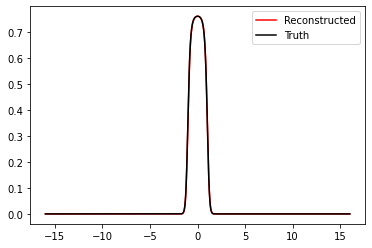

Relative norm difference: 5.0203462420014505e-05


In [9]:
# this code transforms the initial state psi0 to the Fourier basis
# the resulting vector is called inita

psi0choice = 0
def gen_inita():
    def psi0(x, choice=0):
        if choice == 0:
            # rounded box function
            return 1.0 + np.tanh((1 - x**2)/0.5)
        elif choice == 1:
            # triangular pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
        elif choice == 2:
            # parabolic pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
        elif choice == 3:
            # hyperbolic secant squared
            return (np.cosh(x))**(-2)
        elif choice == 4:
            # Laplace
            return np.exp(-np.abs(x))
        else:
            print('Initial State Function: Did not recognise your choice.')
            return None

    # normalize psi0
    norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-bigL, b=bigL)[0])
    def normpsi0(x):
        return psi0(x)/norm

    # transform psi0 to Fourier basis using quadrature method
    # i.e., compute the Fourier coefficients by integration
    vraw = np.zeros(nfb+1, dtype=np.complex128)
    for thisn in range(nfb+1):
        def integ(x):
            return np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
            # return (1 / np.sqrt(2 * bigL)) * np.exp(-1j * np.pi * thisn * x / bigL) * normpsi0(x)
        def rinteg(x):
            return np.real(integ(x))
        def iinteg(x):
            return np.imag(integ(x))
        vraw[thisn] = (1 / np.sqrt(2 * bigL)) * (si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0])
        # vraw[thisn] = si.quad(rinteg, a=-bigL, b=bigL)[0] + 1j * si.quad(iinteg, a=-bigL, b=bigL)[0]

    return np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw]), normpsi0(xvec)

inita, normpsi0true = gen_inita()

# check if the reconstructed psi0 is "close enough" to the true psi0
psi0recon = inita @ convmat
plt.plot(xvec, psi0recon.real, color='red', marker='', linestyle='-', label="Reconstructed")
plt.plot(xvec, normpsi0true.real, color='black', marker='', linestyle='-', label="Truth")
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0 
print('Relative norm difference:', nl.norm(normpsi0true - psi0recon) / nl.norm(normpsi0true))

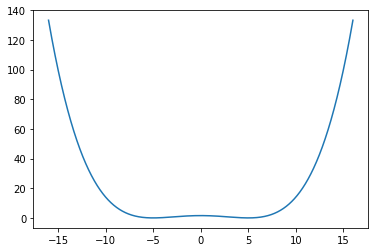

In [10]:
# define potential for generating training data

def v(x, choice=1):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Potential Function: Choice not recognised.')
        return None

# compute true potential
vtrue = v(xvec)

# plot true potential
plt.plot(xvec, vtrue)
plt.show()

In [11]:
# function for generating Gaussian basis matrix (gmat)
def gbmatfn(x1, x2, alpha):
    # make arrays that can be used in vectorized evaluations
    # row values are x1 and column values are x2
    x1v, x2v = np.meshgrid(x1, x2, sparse=True, indexing='ij')

    # vectorized version of Gaussian basis function
    # Gaussian centered at grid point j*h with shape parameter alpha
    # z_{ij} = x_i - j*h
    def gbm(z, alpha):
        return np.exp(-alpha * z**2)

    # make Gaussian basis matrix
    # We want [gbmat @ cfs](x_i) = vtrue(x_i), so each row
    # in gbmat is an x_i point and each column is a j*h
    # point. Given N x_i points and J j values, gbmat
    # is an NxJ matrix
    return gbm(x1v - x2v, alpha)


# function for computing the Gaussian basis coefficients
def gbcfs(fn, J, L, alpha):
    # make vector of x points for Gaussian centers
    # with spacing h
    h = L/J
    xg = np.arange(-J, J+1) * h

    # make Gaussian basis matrix
    gbmat = gbmatfn(xg, xg, alpha)

    # vector of the function evaluated on
    # the xg grid (needed for computing
    # basis coefficients)
    fxgt = fn(xg)

    # solve gbmat @ gbcfs = fxjtrue
    # to compute Gaussian basis coefficients
    # gbmat must be a square matrix
    cfs = sl.solve(gbmat, fxgt, assume_a='sym')

    return cfs, xg



In [36]:
bigJ = 70

# set number of Gaussian basis
ng = 2*bigJ + 1

# alpha determines the amount of overlap of our basis
# it shouldn't be too much or too little, it should also
# scale with the number of basis used.
# values of alpha to try: 4.0, 5.0, 6.0, 7.0
myalpha = 5.0

(141,)
(2000, 141)


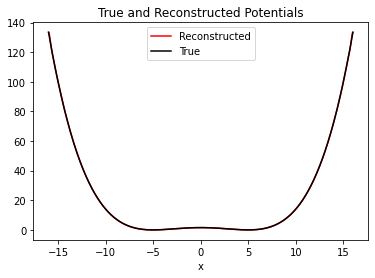

In [37]:
# this code computes the Gaussian basis coefficients
# of the true potential

# We use gmat here because numpy.linalg.inv() requires
# the input matrix be square
cfst, xgvec = gbcfs(v, bigJ, bigL, myalpha)
print(cfst.shape)

# this forms the matrix used for converting Gaussian basis
# coefficients to real space (for plotting)
# xvec is the rows of the matrix, xgvec is the column
gmatplot = gbmatfn(xvec, xgvec, myalpha)
print(gmatplot.shape)

# reconstruct the potential from the Gaussian basis coefficients
vxt = gmatplot @ cfst

# plot real potential vs. reconstructed potential
plt.plot(xvec, vxt, 'r', label='Reconstructed')
plt.plot(xvec, vtrue, 'k', label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

In [13]:
# set number of elements for toeplitz representation
m = 2*nfb + 1

In [14]:
# constants needed for making the potential matrix and its

# gradient
# kspace_n = 2 \pi n / (b - a) --> (b - a) = L + L
# thus kspace_n = \pi n / L
# n = {-2ng, ..., 2ng}, but we only need to look at
# n = {0, ..., 2ng} because the neg values are the
# conjugate of the postive values
ksvec = np.pi * np.arange(0, m) / bigL

cnstexpvec = np.exp(-ksvec ** 2 / (4 * myalpha))

cnsttrmmkgvmat = (1 / (2 * bigL)) * np.sqrt(np.pi / myalpha) * cnstexpvec

In [15]:
# this code computes the potential matrix in the
# Fourier basis given a set of Gaussian basis coefficients.
# this computes the potential matrix directly by FT the Gaussian
# basis model. It should be a linear combo of FT Gaussians.

ksmes, xgmes = np.meshgrid(ksvec, xgvec, sparse=True, indexing='ij')
# this should be a matrix with dimensions (ng x numkspace)
# xg points make the rows and ks points make the columns
cnstgfbmat = np.exp(-1j * ksmes * xgmes)

@njit
# cfs is the vector of Gaussian basis coefficients
def mkgvmat(cfs):
    cfsexpvec = cnstgfbmat @ cfs.astype(np.complex128)
    column = cnsttrmmkgvmat * cfsexpvec
    row = column.conj()
    return toeplitz(r=row, c=column)

In [16]:
# this code computes the gradient of the potential matrix
# in the Fourier basis given a set of Gaussian basis
# coefficients

# this is the gradient of the potential matrix WRT
# the Gaussian coefficients, so it should be a
# tensor of dimensions (ng x nx x nfb) (i.e. the
# potential matrix WRT each of the Gaussian basis functions
gradgvmat = np.zeros((ng, m, m), dtype=np.complex128)
for i in range(ng):
    thiscfs = np.zeros(ng)
    thiscfs[i] = 1
    gradgvmat[i] = mkgvmat(thiscfs)

print(gradgvmat.shape)

(65, 257, 257)


---
**Functions for Propagating System Given Some amat**

In [17]:
# forward propagation
# this code constructions the Hamiltonian matrix
# and performs an eigendecomposition to create 
# the forward propagation matrix, it then propagates
# the given inita nt times steps foward in time

# set the time step size for propagating
dt = 0.01

# set the number of time steps to propagate
nt = 200

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * bigL ** 2))


# define function for propagating system
# nt sets the number of time steps to propagate
# the system in time
# @njit
def propa(gbcff, initapropa, ntpropa=200):
    # form the potential matrix (in the Fourier basis)
    # using a set of Gaussian basis coefficients
    vmatpropa = mkgvmat(gbcff)

    # construct Hamiltonian matrix (in Fourier basis)
    hmatpropa = kmat + vmatpropa

    # eigen-decomposition Hamiltonian matrix
    specpropa, statespropa = np.linalg.eigh(hmatpropa)
    
    # form a vector propagator matrix
    propamat = statespropa @ np.diag( np.exp(-1j * specpropa * dt) ) @ statespropa.T.conj()
    
    # propagate the a vector, i.e., solve the *forward* problem
    amat = np.zeros((ntpropa + 1, 2 * nfb + 1), dtype=np.complex128)
    amat[0, :] = np.copy(initapropa)
    for j in range(ntpropa):
        amat[j + 1, :] = propamat @ amat[j, :]
    
    return specpropa, statespropa, amat

In [18]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

# define function for propagating lambda
# @njit
def proplam(specproplam, statesproplam, amat, amattrueproplam, ntproplam=200):
    # form lambda vector propagator matrix
    proplammat = statesproplam @ np.diag( np.exp(1j * specproplam * dt) ) @ statesproplam.T.conj()

    # propagate lambda vector
    lammat = np.zeros((ntproplam + 1, 2 * nfb + 1), dtype=np.complex128)
    lammat[ntproplam, :] = amat[ntproplam, :] - amattrueproplam[ntproplam, :]
    for j in range(ntproplam - 1, 0, -1):
        lammat[j, :] = amat[j, :] - amattrueproplam[j, :] + proplammat @ lammat[j + 1, :]
    
    return lammat

---
**Compute True amat**

In [19]:
# compute the true propagation from the initial state
# and the true potential

spectrue, statestrue, amattrue = propa(cfst, inita, nt)

# transform amat to real space
psimattrue = amattrue @ convmat

# check if psimattrue is normalized for every time step
print(np.sqrt(np.sum(np.abs(amattrue) ** 2, axis=1)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<h3>Inverse Problem</h3>

**Code for Adjoint Method**

In [20]:
# this code computes the objective function give
# a set of Gaussian basis coefficients as input

def objecfn(cffobjecfn):
    global glbobjechist, glbitercnt
    global glbspec, glbstates, glbamat, glblammat
    
    # propagate initial state with cffobjecfn
    glbspec, glbstates, glbamat = propa(cffobjecfn, inita, nt)
    
    # propagate lambda with glbamat
    glblammat = proplam(glbspec, glbstates, glbamat, amattrue, nt)
    
    # compute objective
    resid = glbamat - amattrue
    objec = 0.5*np.real(np.sum(np.conj(resid)*resid))
    glbitercnt += 1

    # roll the history back one and replace with newest value
    # i.e. put the newest value on the end of the stack
    glbobjechist = np.roll(glbobjechist, -1)
    glbobjechist[-1] = objec
    
    # print the latest values of the Lagrangian
    print(f'{glbitercnt} Lagrangan={glbobjechist[-1]}', end='\x1b[4K\r')
    return objec
    

In [21]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradfnhelp(specprdt, statesprdt):
    dmat = np.zeros((ng, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*specprdt)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(specprdt[ii] - specprdt[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(specprdt[ii]-specprdt[jj]))
    
    for iii in range(ng):
        thisA = statesprdt.conj().T @ gradgvmat[iii] @ statesprdt
        qmat = thisA * mask
        dmat[iii,:,:] = -1j*dt* statesprdt @ qmat @ statesprdt.conj().T

    return dmat
        
def gradfn(_):
    global glbspec, glbstates, glbamat, glblammat, glbdmat
    
    # compute alldmat
    glbdmat = gradfnhelp(glbspec, glbstates)
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblammat[1:, :]), glbdmat, glbamat[:-1, :]))
    return gradients

**Check Functions Using True $\theta$**

In [22]:
# check if the Lagrangian of the true theta, xtrue, gives 0

# set the size of the objective's history
objechistlen = 1
# create the objective's history
glbobjechist = np.zeros(objechistlen)
# initialize variable for counting number of iterations
glbitercnt = 0


objecfn(cfst)

0.0

In [23]:
# check that the gradient of the Lagrangian is zero for the true theta
gradfn(cfst)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

---
**Initialize with true coefficents pertubed by random normally distributed noise**

In [43]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum
cfftrub = cfst.copy()
cfftrub += 0.25*np.random.normal(size=cfst.shape)

In [44]:
print(cfftrub.shape)

(33,)


In [45]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjechist = np.zeros(objechistlen)
# initialize variable for counting number of iterations
glbitercnt = 0

restrub = so.minimize(objecfn, cfftrub, jac=gradfn,
                      options={'maxiter': 5, 'disp': True}) 

         Current function value: 0.002954
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


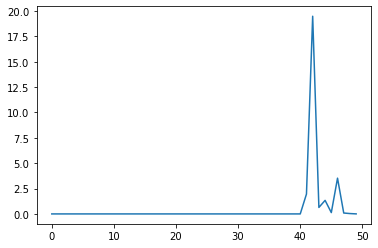

In [46]:
plt.plot(glbobjechist)
plt.show()

In [47]:
# check value of Lagrangian at computed value of theta
print(objecfn(restrub.x))

# check how close predicted coefficents are to
# the coefficents used to make the training data
print(nl.norm(restrub.x - cfst))

0.00295353181426292985318142629298
0.9670981618638697


Prediction vs. Truth:  317.4119271185445
Prediction vs. Training:  5.806345842320775


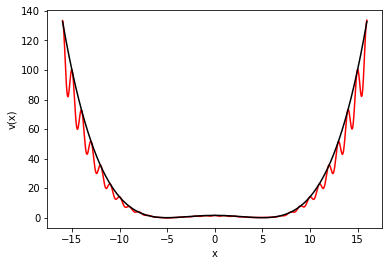

In [48]:
# this code plots the estimated potential against the true potential

# use the machine learned prediction to compute the predicted potential
vturbprdc = gmatplot @ restrub.x

# quantify how close the predicted potential to true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vturbprdc))

# quantify how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(vxt - vturbprdc))

# plot the real part of theta
# red = learned potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vturbprdc[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.show()

---
**Initialize theta with uniform random values**

In [24]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

seed = None  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-0.5, high=0.5, size=cfst.shape) - 0.5

In [25]:
# set the size of the objective's history
objechistlen = 50
# create the objective's history
glbobjechist = np.zeros(objechistlen)
# initialize variable for counting the number of iterations
glbitercnt = 0

resform = so.minimize(objecfn, cffform, jac=gradfn, method='BFGS',
                      options={'disp': True, 'maxiter': 100}).x

Lagrangan=134.6225181195413865 Lagrangan=134.5281423386714467 Lagrangan=134.3330183962948569 Lagrangan=134.279610073098871 Lagrangan=134.2671671090150873 Lagrangan=134.243429366794775 Lagrangan=134.2054542490580277 Lagrangan=134.1814934430492579 Lagrangan=134.1432928234969581 Lagrangan=134.1079556874818583 Lagrangan=134.0980067482484885 Lagrangan=134.079799790824387 Lagrangan=134.064449164430589 Lagrangan=134.058392728171891 Lagrangan=134.0525481732025593 Lagrangan=134.0386755366366295 Lagrangan=134.0222585688371597 Lagrangan=134.0163285334811399 Lagrangan=134.0062657719411101 Lagrangan=133.9752364959109103 Lagrangan=133.91972870131602105 Lagrangan=133.90491113457904107 Lagrangan=133.89788620748195109 Lagrangan=133.88552551761916111 Lagrangan=133.84298513166462113 Lagrangan=133.74882342462388115 Lagrangan=133.68381855256516117 Lagrangan=133.66710865744506119 Lagrangan=133.63666233720576121 Lagrangan=133.5953393610744123 Lagrangan=133.57886622187925125 Lagrangan=133.56476668447016127 La

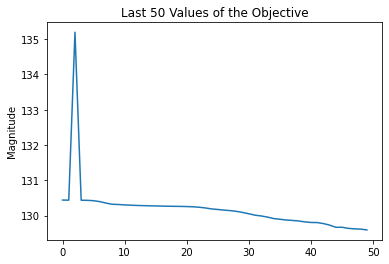

In [26]:
# plot the objective's history
plt.plot(glbobjechist)
plt.title(f'Last {objechistlen} Values of the Objective')
plt.ylabel('Magnitude')
plt.show()

Lagrangian for predicted theta:  129.59189106961324
RND predicted theta vs. true theta:  1.0634266163650903
RND predicted v vs. true v:  1931.3279105155957
RND predicted v vs. training v:  1.026229449038028


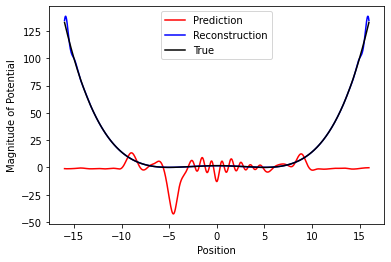

In [27]:
# results

# Print value of objective for predicted theta
print('Lagrangian for predicted theta: ', objecfn(resform))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resform - cfst) / nl.norm(cfst))

# use the predicted theta to compute the predicted potential
vformprdc = gmatplot @ resform

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vtrue - vformprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vxt - vformprdc) / nl.norm(vxt))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vxt[trim:-trim], color='blue', label='Reconstruction')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

**Propagate System with Found Coefficents**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


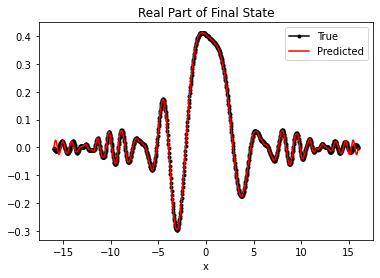

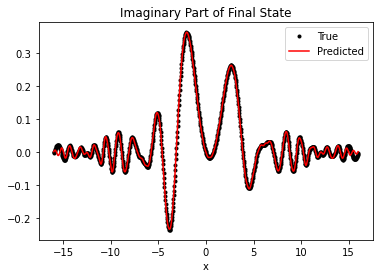

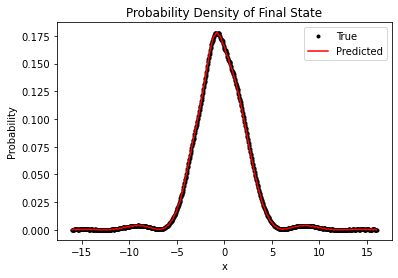

In [30]:
# propagate inita using the predicted coefficients
_, _, amatform, _ = propa(resform.x, inita)
    
# transform amat to real space
psimatform = amatform @ convmat

print('Element difference:\n', psimatform[-1] - psimattrue[-1])
print('Norm of difference:', nl.norm(psimatform - psimattrue))

plt.plot(xvec, psimattrue[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattrue[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattrue[-1])**2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()